### Лабораторная работа №6. Применение сверточных нейронных сетей (многоклассовая классификация)

Данные: Набор данных для распознавания языка жестов, который состоит из изображений размерности 28x28 в оттенках серого (значение пикселя от 0 до 255). Каждое из изображений обозначает букву латинского алфавита, обозначенную с помощью жеста, как показано на рисунке ниже (рисунок цветной, а изображения в наборе данных в оттенках серого). 

Обучающая выборка включает в себя 27,455 изображений, а контрольная выборка содержит 7172 изображения. Данные в виде csv-файлов можно скачать на сайте Kaggle -> https://www.kaggle.com/datamunge/sign-language-mnist

Задание 1.
Загрузите данные. Разделите исходный набор данных на обучающую и валидационную выборки.

Задание 2.
Реализуйте глубокую нейронную сеть со сверточными слоями. Какое качество классификации получено? Какая архитектура сети была использована?

Задание 3.
Примените дополнение данных (data augmentation). Как это повлияло на качество классификатора? 

Задание 4.
Поэкспериментируйте с готовыми нейронными сетями (например, AlexNet, VGG16, Inception и т.п.), применив передаточное обучение. Как это повлияло на качество классификатора? Можно ли было обойтись без него?
Какой максимальный результат удалось получить на контрольной выборке?

Результат выполнения заданий опишите в отчете.

In [1]:
!mkdir -p sign-language-mnist
!unzip sign-language-mnist.zip -d sign-language-mnist

Archive:  sign-language-mnist.zip
  inflating: sign-language-mnist/amer_sign2.png  
  inflating: sign-language-mnist/amer_sign3.png  
  inflating: sign-language-mnist/american_sign_language.PNG  
  inflating: sign-language-mnist/sign_mnist_test.csv  
  inflating: sign-language-mnist/sign_mnist_test/sign_mnist_test.csv  
  inflating: sign-language-mnist/sign_mnist_train.csv  
  inflating: sign-language-mnist/sign_mnist_train/sign_mnist_train.csv  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train_data = pd.read_csv('sign-language-mnist/sign_mnist_train.csv')
test_data = pd.read_csv('sign-language-mnist/sign_mnist_test.csv')

train_data.shape, test_data.shape

((27455, 785), (7172, 785))

In [3]:
train_data.label.unique()

array([ 3,  6,  2, 13, 16,  8, 22, 18, 10, 20, 17, 19, 21, 23, 24,  1, 12,
       11, 15,  4,  0,  5,  7, 14])

Почему-то отсутствует 9-ый класс, переназначим 24 на 9

In [4]:
train_labels = train_data['label'].values
test_labels = test_data['label'].values

train_labels = [9 if label == 24 else label for label in train_labels]
test_labels = [9 if label == 24 else label for label in test_labels]

In [5]:
from sklearn.model_selection import train_test_split

train_data.drop(columns='label', inplace=True)
test_data.drop(columns='label', inplace=True)

train_images, val_images, train_labels, val_labels = train_test_split(
    train_data.values,
    train_labels,
    test_size=0.2,
    stratify=train_labels
)

train_images = train_images.reshape(-1, 28, 28, 1)
val_images = val_images.reshape(-1, 28, 28, 1)

test_images = test_data.values
test_images = test_images.reshape(-1, 28, 28, 1)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, BatchNormalization, Dropout, Flatten

def build_model(num_classes):
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(28, 28, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

In [7]:
model = build_model(num_classes=len(np.unique(train_labels)))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [8]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 64
train_datagen = ImageDataGenerator(rescale=1/255.)
val_datagen = ImageDataGenerator(rescale=1./255.)
test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow(
    train_images,
    to_categorical(train_labels),
    batch_size=batch_size,
    seed=42,
    shuffle=True,
)

val_generator=val_datagen.flow(
    val_images,
    to_categorical(val_labels),
    batch_size=batch_size,
    shuffle=True,
)

test_generator=test_datagen.flow(
    test_images,
    to_categorical(test_labels),
    batch_size=batch_size,
    shuffle=False
)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_generator, 
    epochs=50,
    validation_data=val_generator,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

model.evaluate(test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 344 steps, validate for 86 steps
Epoch 1/50
344/344 [==============================] - 5s 13ms/step - loss: 1.3075 - accuracy: 0.6150 - val_loss: 2.5484 - val_accuracy: 0.2144
Epoch 2/50
344/344 [==============================] - 2s 7ms/step - loss: 0.2676 - accuracy: 0.9140 - val_loss: 0.0415 - val_accuracy: 0.9987
Epoch 3/50
344/344 [==============================] - 3s 7ms/step - loss: 0.1136 - accuracy: 0.9669 - val_loss: 0.0210 - val_accuracy: 0.9978
Epoch 4/50
344/344 [==============================] - 2s 7ms/step - loss: 0.0577 - accuracy: 0.9842 - val_loss: 0.0149 - val_accuracy: 0.9975
Epoch 5/50
344/344 [==============================] - 2s 6ms/step - loss: 0.0381 - accuracy: 0.9903 - val_loss: 0.0019 - val_accuracy: 1.0000
Epoch 6/50
344/344 [==============================] - 2s 7ms/step - loss: 0.0285 - accuracy: 0.9924 - val_loss: 9.7667e-04 - val_accuracy: 1.0000
Epoch 7/50
344/344 [==============================

[0.14012540002050602, 0.9622142]

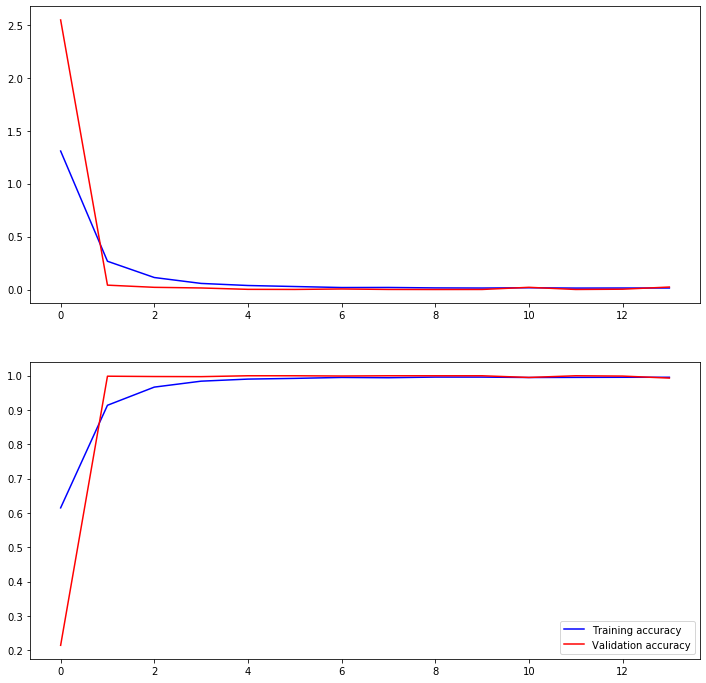

In [10]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

plt.legend()
plt.show()

### Добавим аугментации

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.03,
    horizontal_flip=True
)

val_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow(
    train_images,
    to_categorical(train_labels),
    batch_size=32,
    seed=42,
    shuffle=True
)

val_generator=val_datagen.flow(
    val_images,
    to_categorical(val_labels),
    batch_size=32,
    shuffle=True
)
test_generator=test_datagen.flow(
    test_images,
    to_categorical(test_labels),
    batch_size=32,
    shuffle=False
)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_generator, 
    epochs=50,
    validation_data=val_generator,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

model.evaluate(test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 687 steps, validate for 172 steps
Epoch 1/50
687/687 [==============================] - 12s 18ms/step - loss: 0.6501 - accuracy: 0.8087 - val_loss: 0.0180 - val_accuracy: 0.9969
Epoch 2/50
687/687 [==============================] - 13s 19ms/step - loss: 0.2413 - accuracy: 0.9177 - val_loss: 0.0155 - val_accuracy: 0.9965
Epoch 3/50
687/687 [==============================] - 12s 18ms/step - loss: 0.1723 - accuracy: 0.9435 - val_loss: 0.0046 - val_accuracy: 0.9996
Epoch 4/50
687/687 [==============================] - 13s 19ms/step - loss: 0.1377 - accuracy: 0.9542 - val_loss: 0.0228 - val_accuracy: 0.9924
Epoch 5/50
687/687 [==============================] - 13s 19ms/step - loss: 0.1218 - accuracy: 0.9580 - val_loss: 0.0020 - val_accuracy: 0.9996
Epoch 6/50
687/687 [==============================] - 12s 18ms/step - loss: 0.1025 - accuracy: 0.9662 - val_loss: 0.0115 - val_accuracy: 0.9975
Epoch 7/50
687/687 [======================

[0.5595519281672832, 0.85373676]

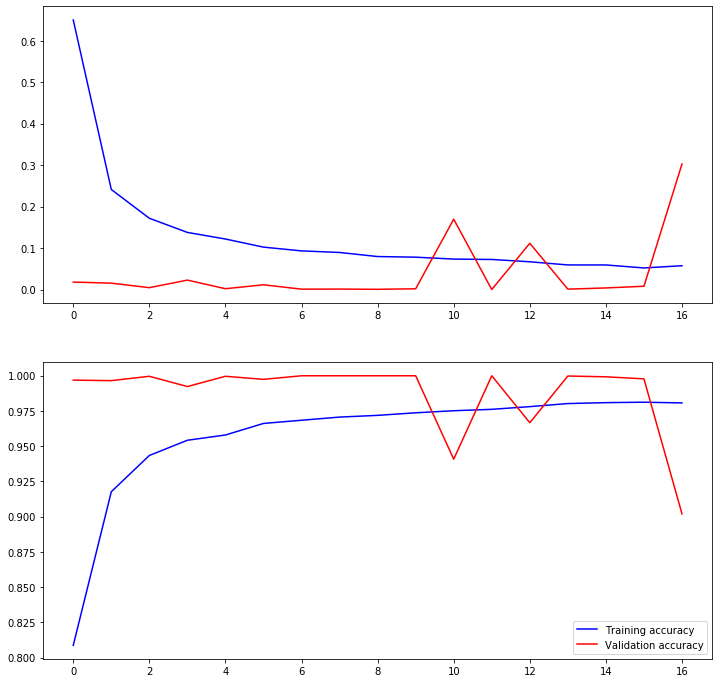

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

plt.legend()
plt.show()

### VGG-16 finetuning

Vgg-16 ожидает входные изображения как минимум 32x32x3: повторим входной канал 3 раза и добавим паддинг по краям

In [14]:
train_images = np.pad(
    np.concatenate([train_images, train_images, train_images], axis=-1),
    ((0, 0), (2, 2), (2, 2), (0, 0))
)

val_images = np.pad(
    np.concatenate([val_images, val_images, val_images], axis=-1),
    ((0, 0), (2, 2), (2, 2), (0, 0))
)

test_images = np.pad(
    np.concatenate([test_images, test_images, test_images], axis=-1),
    ((0, 0), (2, 2), (2, 2), (0, 0))
)

In [15]:
from tensorflow.keras import optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

pre_trained_model = VGG16(input_shape=(32, 32, 3), include_top=False, weights="imagenet")
    
for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output
    
x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(np.unique(train_labels)), activation='softmax')(x)

model = Model(pre_trained_model.input, x)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [16]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
    rotation_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.03,
    horizontal_flip=True
)

val_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=train_datagen.flow(
    train_images,
    to_categorical(train_labels),
    batch_size=32,
    seed=42,
    shuffle=True
)

val_generator=val_datagen.flow(
    val_images,
    to_categorical(val_labels),
    batch_size=32,
    shuffle=True
)
test_generator=test_datagen.flow(
    test_images,
    to_categorical(test_labels),
    batch_size=32,
    shuffle=False
)

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    train_generator, 
    epochs=50,
    validation_data=val_generator,
    workers=4,
    callbacks=[EarlyStopping(patience=5)]
)

model.evaluate(test_generator)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 687 steps, validate for 172 steps
Epoch 1/50
687/687 [==============================] - 16s 24ms/step - loss: 2.7884 - accuracy: 0.1817 - val_loss: 2.0501 - val_accuracy: 0.4779
Epoch 2/50
687/687 [==============================] - 15s 22ms/step - loss: 1.8912 - accuracy: 0.3982 - val_loss: 1.3251 - val_accuracy: 0.6066
Epoch 3/50
687/687 [==============================] - 15s 22ms/step - loss: 1.3840 - accuracy: 0.5377 - val_loss: 0.9856 - val_accuracy: 0.7079
Epoch 4/50
687/687 [==============================] - 15s 22ms/step - loss: 1.0998 - accuracy: 0.6253 - val_loss: 0.7605 - val_accuracy: 0.7531
Epoch 5/50
687/687 [==============================] - 15s 22ms/step - loss: 0.8953 - accuracy: 0.6932 - val_loss: 0.6423 - val_accuracy: 0.7897
Epoch 6/50
687/687 [==============================] - 15s 22ms/step - loss: 0.7655 - accuracy: 0.7370 - val_loss: 0.6266 - val_accuracy: 0.7694
Epoch 7/50
687/687 [======================

[0.16958833215965166, 0.9415784]

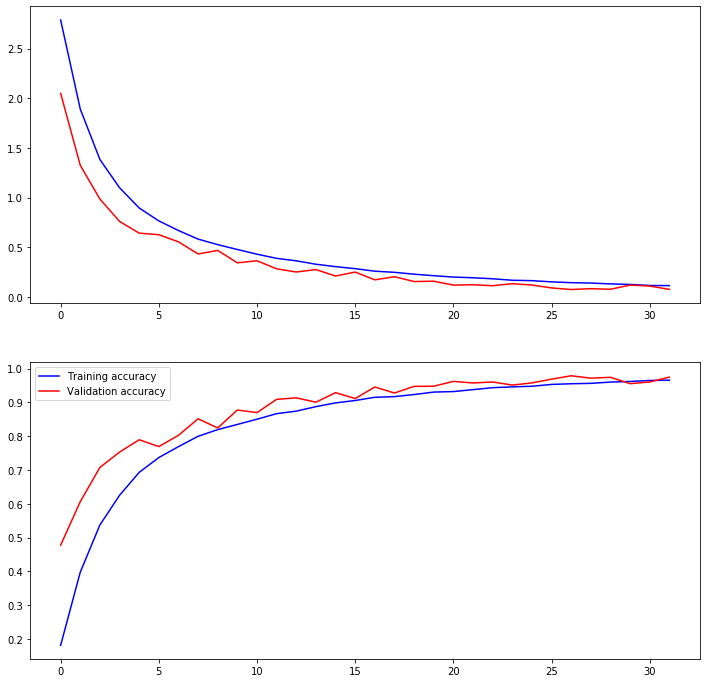

In [18]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")

plt.legend()
plt.show()